# Supervised machine learning with Mol2vec

The notebooks illustrates how Mol2vec can be used to featurize and classify molecules using an Ames mutagenicity benchmark dataset by [Hansen et al.](http://pubs.acs.org/doi/abs/10.1021/ci900161g) as an example.
* [Featurize the molecules using pre-trained Mol2vec model](#Featurize-the-molecules-using-pre-trained-Mol2vec-model)
* [Train and validate Random Forest model trained using Mol2vec vectors](#Train-and-validate-Random-Forest-model-trained-using-Mol2vec-vectors)
* [Featurize molecules from the command line](#Featurize-molecules-from-the-command-line)

In [1]:
% matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

Load the pre-processed [Ames](http://pubs.acs.org/doi/suppl/10.1021/ci900161g) dataset

In [3]:
df = PandasTools.LoadSDF('data/ames.sdf')

,ID,ROMol,class
0,2475-33-4,,0

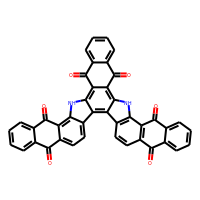

In [4]:
df.head(1)

In [5]:
len(df)

6506

### Featurize the molecules using pre-trained Mol2vec model

Load a pre-trained Mol2vec model which was trained on 20 million compounds downloaded from ZINC using:

* radius 1
* UNK to replace all identifiers that appear less than 4 times
* skip-gram and window size of 10
* resulting in 300 dimensional embeddings

In [6]:
model = word2vec.Word2Vec.load('models/model_300dim.pkl')

Generate "molecular sentences" that are then used to featurize the molecules (i.e. vectors of identifiers are extracted from Mol2vec model and summed up)

In [7]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

Extract the training data from the data frame

In [8]:
X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['class'].astype(int))

### Train and validate Random Forest model trained using Mol2vec vectors

Performance validation is done by stratified K-fold (4-fold CV) with shuffling

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [10]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [12]:
y_values = []
predictions = []
probas = []
for train, test in kf.split(X, y):
    clf.fit(X[train], y[train])
    predictions.append(clf.predict(X[test]))
    probas.append(clf.predict_proba(X[test]).T[1]) # Probabilities for class 1
    y_values.append(y[test])

Calculate performance metrics and plot them (ROC AUC)

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [14]:
aucs = [roc_auc_score(y, proba) for y, proba in zip(y_values, probas)]

In [15]:
np.mean(aucs), np.std(aucs)

(0.86203408715705998, 0.0044217056810015899)

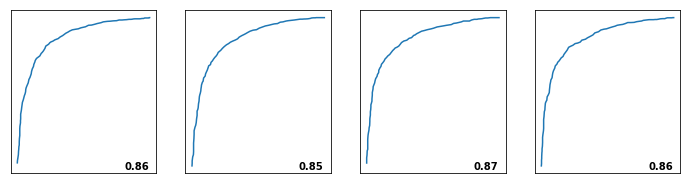

In [16]:
f, ((p1, p2, p3, p4)) = plt.subplots(1,4, squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(12,3))

for y,proba,ax in zip(y_values, probas, (p1,p2,p3,p4)):
    tpr, fpr, _ = roc_curve(y, proba)
    auc = roc_auc_score(y, proba)
    ax.plot(tpr, fpr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%0.2f" % auc,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)
plt.show()

### Featurize molecules from the command line

Alternative to using Python functions is the command line `mol2vec` application. Type `mol2vec -h` for more information.

Calling command line application from Jupyter notebook

In [17]:
!mol2vec featurize -i data/ames.sdf -o data/ames.csv -m models/model_300dim.pkl --uncommon UNK -r 1 

Featurizing molecules.
Loading molecules.
Keeping only molecules that can be processed by RDKit.
Featurizing molecules.
Done!


Load embedding generated by the `mol2vec` application

In [18]:
df_2 = pd.read_csv('data/ames.csv', index_col=[0])

Not that unlike above where Mol2vec vectors are stored is data frame cells as DfVec objects command line application stores each dimension of the vectors as separate column (*mol2vec-000* to *mol2vec-n-dimensions*).

In [19]:
df_2.head()

,ID,class,Smiles,mol2vec-000,mol2vec-001,mol2vec-002,mol2vec-003,mol2vec-004,mol2vec-005,mol2vec-006,mol2vec-007,mol2vec-008,mol2vec-009,mol2vec-010,mol2vec-011,mol2vec-012,mol2vec-013,mol2vec-014,mol2vec-015,mol2vec-016,mol2vec-017,mol2vec-018,mol2vec-019,mol2vec-020,mol2vec-021,mol2vec-022,mol2vec-023,mol2vec-024,mol2vec-025,mol2vec-026,mol2vec-027,mol2vec-028,mol2vec-029,mol2vec-030,mol2vec-031,mol2vec-032,mol2vec-033,mol2vec-034,mol2vec-035,mol2vec-036,mol2vec-037,mol2vec-038,mol2vec-039,mol2vec-040,mol2vec-041,mol2vec-042,mol2vec-043,mol2vec-044,mol2vec-045,mol2vec-046,mol2vec-047,mol2vec-048,mol2vec-049,mol2vec-050,mol2vec-051,mol2vec-052,mol2vec-053,mol2vec-054,mol2vec-055,mol2vec-056,mol2vec-057,mol2vec-058,mol2vec-059,mol2vec-060,mol2vec-061,mol2vec-062,mol2vec-063,mol2vec-064,mol2vec-065,mol2vec-066,mol2vec-067,mol2vec-068,mol2vec-069,mol2vec-070,mol2vec-071,mol2vec-072,mol2vec-073,mol2vec-074,mol2vec-075,mol2vec-076,mol2vec-077,mol2vec-078,mol2vec-079,mol2vec-080,mol2vec-081,mol2vec-082,mol2vec-083,mol2vec-084,mol2vec-085,mol2vec-086,mol2vec-087,mol2vec-088,mol2vec-089,mol2vec-090,mol2vec-091,mol2vec-092,mol2vec-093,mol2vec-094,mol2vec-095,mol2vec-096,mol2vec-097,mol2vec-098,mol2vec-099
0,2475-33-4,0,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c(ccc5c(=O)c6ccccc6c(=O)c54)c3c12,1.508495,16.190434,-14.119161,-9.726344,-21.809919,-6.156873,-14.111709,-17.807381,-6.918430,-22.019386,37.893082,-15.363530,0.826183,-15.695942,-14.276697,0.885753,-7.002637,18.922380,1.114347,-7.537972,-23.718891,18.226259,-21.002163,17.209488,7.468110,-3.545178,1.290942,-18.058281,0.321039,8.780219,4.362634,24.616972,41.665722,13.534548,-25.513752,-19.605495,21.018059,28.713505,-16.529842,25.678499,24.622299,-18.404888,2.160755,-11.676982,-7.866406,-24.687023,-19.845835,2.177311,37.311127,19.860867,7.197349,12.437116,3.282497,11.875668,6.812393,26.921173,-16.292723,-11.626889,11.431473,-2.098175,-5.489677,2.093878,27.250177,12.065416,7.379858,-16.753168,6.207857,35.563526,-12.520493,31.326872,0.438330,-18.576080,17.376793,2.976248,-18.113392,-11.361904,15.463422,21.931627,8.067935,-33.712868,25.160355,17.299822,18.786873,-14.851186,-43.918865,31.888794,-8.152823,53.270042,-1.094527,-4.297421,25.840403,20.213745,-6.010414,-26.472733,19.143162,-46.500988,6.726566,37.054325,-25.272833,-13.204696
1,105149-00-6,0,CC(=O)OC1(C(C)=O)CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)C3CCC21C,-8.966455,9.104663,-7.976571,-16.271759,-8.041543,-11.308760,-10.655948,-7.588518,1.783487,-2.829623,14.464226,-15.046628,-1.645419,-4.858140,-7.622559,-7.922463,-4.475996,5.296366,-4.006516,-21.238514,-12.001178,24.830645,-17.268602,3.909588,20.541258,0.956757,-6.749233,-4.418837,23.610081,-6.082169,-7.483197,3.208025,14.079184,-3.309254,-14.329214,-6.618795,8.495410,11.881017,-12.764916,11.824277,8.845399,3.448039,7.107430,-7.130319,-8.986353,-5.519269,-20.537428,11.829369,24.178478,25.863245,9.694634,-6.950540,-8.792462,2.247250,-4.894259,2.227847,-2.983115,-2.301332,8.003473,1.260265,-4.420463,-8.187524,8.408403,0.599265,-22.527445,-16.909718,-1.344561,17.060337,-1.161264,13.063327,-7.443371,0.563754,18.825546,2.995440,-13.640258,-1.070554,-10.143273,3.756449,-10.807425,-7.486877,12.647701,13.398089,-0.030032,-6.138687,-12.674323,8.441009,-4.311833,21.088312,-8.426578,0.248262,28.123075,1.457259,-6.687270,-17.077105,27.455225,-20.962904,18.626863,9.318312,-20.484341,0.304023
2,108-78-1,0,Nc1nc(N)nc(N)n1,0.633942,-1.644197,0.024865,-3.244659,-4.360913,-2.608974,3.167715,-5.261040,-0.902429,-9.350870,7.629671,-8.225711,-2.775155,-3.911475,-0.116474,-3.360920,-2.432252,4.492410,-4.376824,0.507320,-0.675704,0.141628,-2.156520,2.213037,0.124711,0.548280,-3.024824,-2.906931,-1.639305,-2.958260,0.709627,1.209152,9.949347,0.168034,-0.882161,-6.418396,7.900039,0.998949,-7.578548,4.756392,6.111425,-3.382147,-3.199611,-4.581319,-1.864795,-10.065327,-6.299738,1.965715,7.079899,-3.490194,0.694833,4.674243,-0.703957,1.007943,1.300453,2.986419,2.812267,-5.383341,-2.318025,1.

Extracting features for the machine learning

In [20]:
X = np.array(df_2[[x for x in df_2.columns if 'mol2vec' in x]])

In [21]:
X.shape

(6506, 100)